In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Define the neural network
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Physics loss: dy/dx - x = 0
def physics_loss(model, x):
    x.requires_grad = True
    y = model(x)
    dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y),
                                create_graph=True, retain_graph=True)[0]
    return torch.mean((dy_dx - x) ** 2)

# Initial condition loss: y(0) = 0
def initial_condition_loss(model):
    x0 = torch.tensor([[0.0]], requires_grad=True)
    y0 = model(x0)
    return torch.mean((y0 - 0.0) ** 2)

# Training loop
def train(model, optimizer, epochs=500):
    tloss=[]
    for epoch in range(epochs):
        optimizer.zero_grad()
        x_collocation = torch.linspace(0, 1, 100).view(-1, 1)
        loss_pde = physics_loss(model, x_collocation)
        loss_ic = initial_condition_loss(model)
        loss = loss_pde + loss_ic
        tloss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    return tloss

In [41]:
# Main script
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
a = train(model, optimizer)

Epoch 0, Loss: 0.375167
Epoch 100, Loss: 0.016408
Epoch 200, Loss: 0.000684
Epoch 300, Loss: 0.000335
Epoch 400, Loss: 0.000223


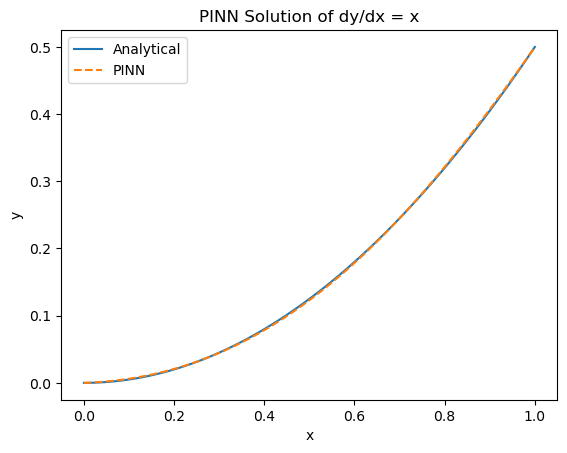

In [42]:
# Plot result
x_test = torch.linspace(0, 1, 100).view(-1, 1)
y_pred = model(x_test).detach().numpy()
y_true = 0.5 * x_test.numpy()** 2

plt.plot(x_test, y_true, label='Analytical')
plt.plot(x_test, y_pred, '--', label='PINN')
plt.legend()
plt.xlabel('x'); plt.ylabel('y')
plt.title('PINN Solution of dy/dx = x')
plt.show()

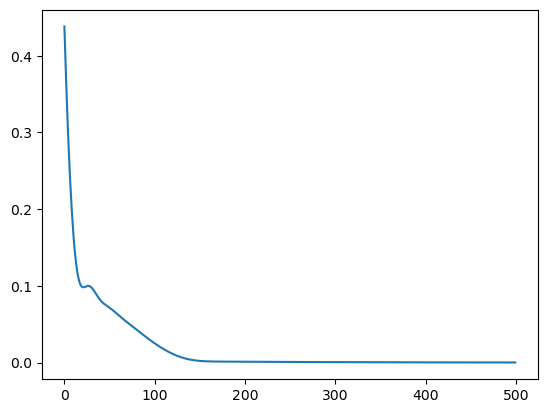

In [34]:
plt.plot(a)